In [1]:
import nibabel as nib
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.ticker import FormatStrFormatter
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import sys
import os
from skimage import measure

In [3]:
dwi_file = nib.load('/nfs/masi/kanakap/projects/LR_tract/MASiVar_kids/sub-cIVs001/ses-s1Bx2/prequal_dwi_cat/sub-cIVs001_ses-s1Bx2_acq-b1000b2000n96r21x21x22peAPP_run-1_dwi.nii.gz').get_fdata()
bvals_file = '/nfs/masi/kanakap/projects/LR_tract/MASiVar_kids/sub-cIVs001/ses-s1Bx2/prequal_dwi_cat/sub-cIVs001_ses-s1Bx2_acq-b1000b2000n96r21x21x22peAPP_run-1_dwi.bval'
dwi_unbiased_file = nib.load('/nfs/masi/kanakap/projects/LR_tract/MASiVar_kids/sub-cIVs001/ses-s1Bx2/tracto_ip_lr_corr_1/emp_Lcorrected_sig.nii.gz').get_fdata()
l = nib.load('/home/local/VANDERBILT/kanakap/L.nii.gz').get_fdata()
mask = nib.load('/nfs/masi/kanakap/projects/LR_tract/MASiVar_kids/sub-cIVs001/ses-s1Bx2/prequal_dwi_cat/mrtrix_mask.nii').get_fdata()

In [66]:
dwi_file = '/nfs/masi/kanakap/projects/LR_tract/MASiVar_kids/sub-cIVs001/ses-s1Bx2/prequal_dwi_cat/sub-cIVs001_ses-s1Bx2_acq-b1000b2000n96r21x21x22peAPP_run-1_dwi.nii.gz'
bvals_file = '/nfs/masi/kanakap/projects/LR_tract/MASiVar_kids/sub-cIVs001/ses-s1Bx2/prequal_dwi_cat/sub-cIVs001_ses-s1Bx2_acq-b1000b2000n96r21x21x22peAPP_run-1_dwi.bval'
dwi_unbiased_file = '/nfs/masi/kanakap/projects/LR_tract/MASiVar_kids/sub-cIVs001/ses-s1Bx2/tracto_ip_lr_corr_1/emp_Lcorrected_sig.nii.gz'
bias_field_file = '/home/local/VANDERBILT/kanakap/L.nii.gz'
mask_file = '/nfs/masi/kanakap/projects/LR_tract/MASiVar_kids/sub-cIVs001/ses-s1Bx2/prequal_dwi_cat/mrtrix_mask.nii'

In [2]:
def plot_slice(slices, img_dim, offset_index, vox_dim, img_min, img_max, alpha=1, cmap='gray'):

    s = slices[img_dim]
    if img_dim == 0:
        s = s[offset_index, :, :]
        vox_ratio = vox_dim[2]/vox_dim[1]
    elif img_dim == 1:
        s = s[:, offset_index, :]
        vox_ratio = vox_dim[2]/vox_dim[0]
    elif img_dim == 2:
        s = s[:, :, offset_index]
        vox_ratio = vox_dim[1]/vox_dim[0]
    s = np.rot90(np.squeeze(s))
    im = plt.imshow(s, cmap=cmap, vmin=img_min, vmax=img_max, aspect=vox_ratio, alpha=alpha)
    plt.xticks([], [])
    plt.yticks([], [])
    return im

In [64]:
# dwi_file = '/nfs/masi/kanakap/projects/LR_tract/MASiVar_kids/sub-cIVs096/ses-s1Bx1/prequal_dwi_cat/sub-cIVs096_ses-s1Bx1_acq-b1000b2000n96r21x21x22peAPP_run-1_dwi.nii'
bvals_file = '/nfs/masi/kanakap/projects/LR_tract/MASiVar_kids/sub-cIVs096/ses-s1Bx1/prequal_dwi_cat/sub-cIVs096_ses-s1Bx1_acq-b1000b2000n96r21x21x22peAPP_run-1_dwi.bval'
dwi_corr_file = '/nfs/masi/kanakap/projects/LR/test_prequal_local/Lcorrected_sig.nii.gz'
grad_field_file = '/nfs/masi/kanakap/projects/LR/test_prequal_local/L_resamp.nii.gz'
fa_grad_field_file = '/nfs/masi/kanakap/projects/LR/test_prequal_local/fa_file_direct.nii'
# fa_grad_field_file = '/nfs/masi/kanakap/projects/LR/test_prequal_local/python.nii'
mask_file = '/nfs/masi/kanakap/projects/LR_tract/MASiVar_kids/sub-cIVs096/ses-s1Bx1/prequal_dwi_cat/mrtrix_mask.nii'#tracto_op_1_est/sub-cIVs096_ses-s1Bx1__b0_mask_resampled.nii.gz'

In [40]:
!pip install opencv-python

  Using cached opencv_python-4.6.0.66-cp36-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (60.9 MB)


In [60]:
mask_slices, mask_vox_dim, mask_min, mask_max = slice_nii(mask_file, min_intensity=0, max_percentile=90)
# mask_slices = simple_edge_detection(np.squeeze(mask_slices[0]))

/tmp/ipykernel_1150903/2225429671.py:4: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  img = nii.get_data()
/tmp/ipykernel_1150903/2225429671.py:21: DeprecationWarning: get_header method is deprecated.
Please use the ``img.header`` property instead.

* deprecated from version: 2.1
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 4.0
  hdr = nii.get_header()


In [71]:
def vis_bias(bvals_file, dwi_corr_file, grad_field_file, fa_grad_field_file):


    print('VISUALIZING GRADIENT NONLINEARITY FIELD CORRECTION')

    temp_dir = 'TMP'
    b0_corr_file, _, _ = dwi_extract(dwi_corr_file, bvals_file, temp_dir, target_bval=1000, first_only=True)
    b0_corr_slices, b0_corr_vox_dim, b0_corr_min, b0_corr_max = slice_nii(b0_corr_file, min_intensity=0, max_percentile=90)

    mask_slices, _, _, _ = slice_nii(mask_file)
    grad_field_slices, grad_field_vox_dim, grad_field_min, grad_field_max = slice_grad_nii(grad_field_file)#, min_intensity=0, max_percentile=90)
    fa_grad_field_slices, fa_grad_field_vox_dim, fa_grad_field_min, fa_grad_field_max = slice_nii(fa_grad_field_file)#, min_intensity=0, max_percentile=50)

    # plt.figure(0, 5)

    plt.subplot(3, 3, 1)
    plot_slice_contour(mask_slices, img_dim=0, offset_index=0, color='b')
    plot_slice(slices=b0_corr_slices, img_dim=0, offset_index=0, vox_dim=b0_corr_vox_dim, img_min=b0_corr_min, img_max=b0_corr_max)
    plt.colorbar()
    plt.title('Corrected')
    plt.ylabel('Sagittal')

    plt.subplot(3, 3, 4)
    plot_slice_contour(mask_slices, img_dim=1, offset_index=0, color='b')
    plot_slice(slices=b0_corr_slices, img_dim=1, offset_index=0, vox_dim=b0_corr_vox_dim, img_min=b0_corr_min, img_max=b0_corr_max)
    plt.colorbar()
    plt.ylabel('Coronal')

    plt.subplot(3, 3, 7)
    plot_slice_contour(mask_slices, img_dim=2, offset_index=0, color='b')
    plot_slice(slices=b0_corr_slices, img_dim=2, offset_index=0, vox_dim=b0_corr_vox_dim, img_min=b0_corr_min, img_max=b0_corr_max)
    plt.colorbar()
    plt.ylabel('Axial')

    plt.subplot(3, 3, 2)
    plot_slice_contour(mask_slices, img_dim=0, offset_index=0, color='b')#, min_intensity=0, max_percentile=90)
    plot_slice(slices=grad_field_slices, img_dim=0, offset_index=0, vox_dim=grad_field_vox_dim, img_min=grad_field_min, img_max=grad_field_max)#,  cmap=shifted_cmap)
    plt.colorbar()
    plt.title('Det of \ngradtensor')#erminant of \nNonlinear Gradient Field')

    plt.subplot(3, 3, 5)
    plot_slice_contour(mask_slices, img_dim=1, offset_index=0, color='b')#, min_intensity=0, max_percentile=90)
    plot_slice(slices=grad_field_slices, img_dim=1, offset_index=0, vox_dim=grad_field_vox_dim, img_min=grad_field_min, img_max=grad_field_max)
    plt.colorbar()

    plt.subplot(3, 3, 8)
    plot_slice_contour(mask_slices, img_dim=2, offset_index=0, color='b')#, min_intensity=0, max_percentile=90)
    plot_slice(slices=grad_field_slices, img_dim=2, offset_index=0, vox_dim=grad_field_vox_dim, img_min=grad_field_min, img_max=grad_field_max)
    plt.colorbar()

    plt.subplot(3, 3, 3)
    plot_slice(slices=fa_grad_field_slices, img_dim=0, offset_index=0, vox_dim=fa_grad_field_vox_dim, img_min=1.15, img_max=1.16)
    plt.colorbar()
    plt.title('FA of \ngradtensor')

    plt.subplot(3, 3, 6)
    plot_slice(slices=fa_grad_field_slices, img_dim=1, offset_index=0, vox_dim=fa_grad_field_vox_dim, img_min=1.15, img_max=1.16)
    plt.colorbar()

    plt.subplot(3, 3, 9)
    plot_slice(slices=fa_grad_field_slices, img_dim=2, offset_index=0, vox_dim=fa_grad_field_vox_dim, img_min=1.15, img_max=1.16)
    plt.colorbar()

    plt.tight_layout()

    plt.subplots_adjust(top=0.925)
    plt.suptitle('Nonliear Gradient Field Correction')

    # bias_vis_file = os.path.join(vis_dir, 'bias.pdf')
    # plt.savefig(bias_vis_file, dpi=SHARED_VARS.PDF_DPI)
    # plt.close()




VISUALIZING GRADIENT NONLINEARITY FIELD CORRECTION
EXTRACTING FIRST B = 1000 VOLUME(S) FROM Lcorrected_sig


/tmp/ipykernel_1150903/2225429671.py:4: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  img = nii.get_data()
/tmp/ipykernel_1150903/2225429671.py:21: DeprecationWarning: get_header method is deprecated.
Please use the ``img.header`` property instead.

* deprecated from version: 2.1
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 4.0
  hdr = nii.get_header()


EXTRACTING FIRST VOLUME ONLY => 3D OUTPUT
EXTRACTED IMAGE HAS SHAPE (112, 112, 54)


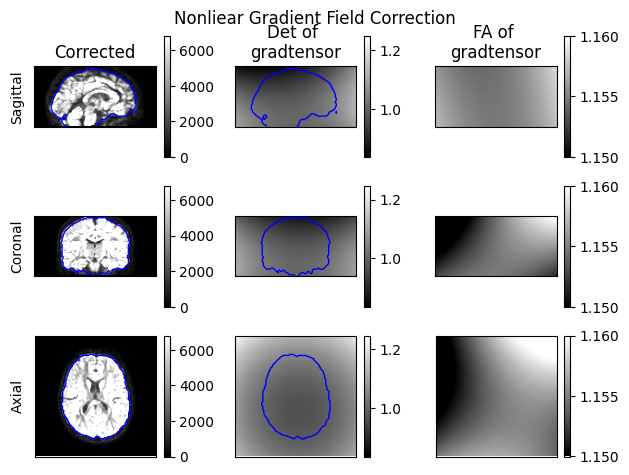

In [72]:
vis_bias(bvals_file, dwi_corr_file, grad_field_file, fa_grad_field_file)

In [17]:
import matplotlib
orig_cmap = matplotlib.cm.gray
shifted_cmap = shiftedColorMap(orig_cmap, midpoint=1, name='shifted')

In [5]:
def load_nii(nii_file, dtype='', ndim=-1):

    nii = nib.load(nii_file)
    img = nii.get_data()

    if not dtype == '':
        img = img.astype(dtype)
    if len(img.shape) < 3 or len(img.shape) > 4:
        print('CANNOT LOAD NIFTI IMAGES THAT ARE NOT 3D OR 4D. REQUESTED IMAGE TO LOAD IS {}D.'.format(len(img.shape)))
    if ndim == 3 or ndim == 4:
        if ndim > len(img.shape): # ndim = 4, img = 3
            img = np.expand_dims(img, axis=3)
        elif ndim < len(img.shape): # ndim = 3, img = 4
            if img.shape[-1] == 1:
                img = img[..., 0]
            else:
                print('CANNOT LOAD NIFTI IMAGE WITH FEWER DIMENSIONS THAT IT ALREADY HAS. REQUESTED {} DIMS, HAS {} DIMS'.format(ndim, len(img.shape)))

    img = np.array(img)
    aff = nii.affine
    hdr = nii.get_header()

    return img, aff, hdr

In [6]:
def _radiological_view(img, aff, vox_dim=(1, 1, 1)):

    # RAS defined by nibabel as L->R, P->A, I->S. Orientation functions from nibabel assume this.
    # "Radiological view" is LAS. Want to view in radiological view for doctors.
    # NIFTIs are required to have world coordinates in RAS.

    # Some helpful links:
    # https://users.fmrib.ox.ac.uk/~paulmc/fsleyes/userdoc/latest/display_space.html#radiological-vs-neurological
    # https://fsl.fmrib.ox.ac.uk/fsl/fslwiki/Orientation%20Explained

    orientations = nib.orientations.io_orientation(aff) # Get orientations relative to RAS in nibabel

    old_axis_order = np.array(orientations[:, 0]) # Permute to get RL, AP, IS axes in right order
    new_axis_order = np.array([0, 1, 2])
    permute_axis_order = list(np.array([new_axis_order[old_axis_order == 0],
                                        new_axis_order[old_axis_order == 1],
                                        new_axis_order[old_axis_order == 2]]).flatten())
    img = np.transpose(img, axes=permute_axis_order)
    orientations_permute = orientations[permute_axis_order]

    vox_dim = np.array(vox_dim)[permute_axis_order] # Do the same to reorder pixel dimensions

    for orientation in orientations_permute: # Flip axes as needed to get R/A/S as positive end of axis (into radiological view)
        if (orientation[1] == 1 and orientation[0] == 0) or (orientation[1] == -1 and orientation[0] > 0):
            img = nib.orientations.flip_axis(img, axis=orientation[0].astype('int'))
    
    return img, vox_dim

In [7]:
def slice_grad_nii(nii_file, offsets=[0], custom_aff=[], min_percentile=0, max_percentile=100, min_intensity=np.nan, max_intensity=np.nan, fa=False):

    img, aff, hdr = load_nii(nii_file, ndim=4)
    img = det_matrix(img)

    # Extract voxel dimensions and reorient image in radiological view
    vox_dim = hdr.get_zooms()
    if len(custom_aff) > 0:
        aff = custom_aff
    img, vox_dim = _radiological_view(img, aff, vox_dim)

    # Extract min and max of entire volume so slices can be plotted with homogenous scaling

    if np.isnan(min_intensity):
        img_min = np.nanpercentile(img, min_percentile)
    else:
        img_min = min_intensity
        
    if np.isnan(max_intensity):
        img_max = np.nanpercentile(img, max_percentile)
    else:
        img_max = max_intensity

    # Extract center triplanar slices with offsets.

    i0 = int(round(img.shape[0] / 2, 1))
    i1 = int(round(img.shape[1] / 2, 1))
    i2 = int(round(img.shape[2] / 2, 1))

    i0s = []
    i1s = []
    i2s = []
    for offset in offsets:
        i0s.append(i0 + offset)
        i1s.append(i1 + offset)
        i2s.append(i2 + offset)

    s0s = img[i0s, :, :]
    s1s = img[:, i1s, :]
    s2s = img[:, :, i2s]

    slices = (s0s, s1s, s2s)

    return slices, vox_dim, img_min, img_max

In [8]:
def slice_nii(nii_file, offsets=[0], custom_aff=[], min_percentile=0, max_percentile=100, min_intensity=np.nan, max_intensity=np.nan):

    img, aff, hdr = load_nii(nii_file, ndim=3)

    # Extract voxel dimensions and reorient image in radiological view
    vox_dim = hdr.get_zooms()
    if len(custom_aff) > 0:
        aff = custom_aff
    img, vox_dim = _radiological_view(img, aff, vox_dim)

    # Extract min and max of entire volume so slices can be plotted with homogenous scaling

    if np.isnan(min_intensity):
        img_min = np.nanpercentile(img, min_percentile)
    else:
        img_min = min_intensity
        
    if np.isnan(max_intensity):
        img_max = np.nanpercentile(img, max_percentile)
    else:
        img_max = max_intensity

    # Extract center triplanar slices with offsets.

    i0 = int(round(img.shape[0] / 2, 1))
    i1 = int(round(img.shape[1] / 2, 1))
    i2 = int(round(img.shape[2] / 2, 1))

    i0s = []
    i1s = []
    i2s = []
    for offset in offsets:
        i0s.append(i0 + offset)
        i1s.append(i1 + offset)
        i2s.append(i2 + offset)

    s0s = img[i0s, :, :]
    s1s = img[:, i1s, :]
    s2s = img[:, :, i2s]

    slices = (s0s, s1s, s2s)

    # Output Descriptions:

    # slices: a list of sagittal, coronal, and axial volumes.
    # - slices[1] gives the coronal volume
    # - slices[1][:, 0, :] gives the first coronal slices offset offsets[0] from the center coronal slice
    # - np.rot90(np.squeeze(slices[1][:, 0, :])) prepares it for plotting
    # vox_dim: a list of 3 values corresponding to the real-life sizes of each voxel, needed for proper axis scaling when plotting slices
    # img_min and img_max: the min and max values of the img volume, needed for proper homogenous intensity scaling when plotting different slices

    return slices, vox_dim, img_min, img_max

In [9]:
def load_txt(txt_file, txt_type=''): 

    txt_data = np.loadtxt(txt_file)
    if txt_type == 'bvals':
        if len(txt_data.shape) == 0:
            txt_data = np.array([txt_data])
    elif txt_type == 'bvecs':
        if len(txt_data.shape) == 1:
            txt_data = np.expand_dims(txt_data, axis=1)
    return txt_data

In [10]:
def save_nii(img, aff, nii_file, dtype='', ndim=-1):

    if not dtype == '':
        img = img.astype(dtype)
    if len(img.shape) < 3 or len(img.shape) > 4:
        print('CANNOT SAVE NIFTI IMAGES THAT ARE NOT 3D OR 4D. REQUESTED IMAGE TO SAVE IS {}D.'.format(len(img.shape)))
    if ndim == 3 or ndim == 4:
        if ndim > len(img.shape): # ndim = 4, img = 3
            img = np.expand_dims(img, axis=3)
        elif ndim < len(img.shape): # ndim = 3, img = 4
            if img.shape[-1] == 1:
                img = img[..., 0]
            else:
                print('CANNOT SAVE NIFTI IMAGE WITH FEWER DIMENSIONS THAT IT ALREADY HAS. REQUESTED {} DIMS, HAS {} DIMS'.format(ndim, len(img.shape)))

    nii = nib.Nifti1Image(img, aff)
    nib.save(nii, nii_file)

In [11]:
def get_prefix(file_path, file_ext='nii'):

    return os.path.split(file_path)[-1].split('.{}'.format(file_ext))[0]

In [12]:
def dwi_extract(dwi_file, bvals_file, extract_dir, target_bval=0, first_only=False):

    dwi_prefix = get_prefix(dwi_file)

    print('EXTRACTING {} {} VOLUME(S) FROM {}'.format('FIRST' if first_only else 'ALL', 'B = {}'.format(target_bval), dwi_prefix))

    dwi_img, dwi_aff, _ = load_nii(dwi_file, ndim=4)
    bvals = load_txt(bvals_file, txt_type='bvals')

    num_total_vols = dwi_img.shape[3]
    index = np.array(range(0, num_total_vols))
    index = index[bvals == target_bval]

    if first_only:

        print('EXTRACTING FIRST VOLUME ONLY => 3D OUTPUT')
        dwi_extracted_img = dwi_img[:, :, :, index[0]]
        num_extracted_vols = 1

    else:

        print('EXTRACTING ALL VALID VOLUMES => 4D OUTPUT')
        dwi_extracted_img = dwi_img[:, :, :, index]
        num_extracted_vols = len(index)

    print('EXTRACTED IMAGE HAS SHAPE {}'.format(dwi_extracted_img.shape))

    dwi_extracted_file = os.path.join(extract_dir, '{}_b{}_{}.nii.gz'.format(dwi_prefix, target_bval, 'first' if first_only else 'all'))
    save_nii(dwi_extracted_img, dwi_aff, dwi_extracted_file, ndim=4)

    return dwi_extracted_file, num_extracted_vols, num_total_vols

In [13]:
def det_matrix(l):
        x_dim = l.shape[0]
        y_dim = l.shape[1]
        z_dim = l.shape[2]
        vL = np.zeros((3,3,x_dim,y_dim,z_dim))
        vL[0,0,:,:,:] = l[:,:,:,0]
        vL[0,1,:,:,:] = l[:,:,:,1]
        vL[0,2,:,:,:] = l[:,:,:,2]
        vL[1,0,:,:,:] = l[:,:,:,3]
        vL[1,1,:,:,:] = l[:,:,:,4]
        vL[1,2,:,:,:] = l[:,:,:,5]
        vL[2,0,:,:,:] = l[:,:,:,6]
        vL[2,1,:,:,:] = l[:,:,:,7]
        vL[2,2,:,:,:] = l[:,:,:,8]

        L_det = np.zeros((x_dim,y_dim,z_dim))

        # Along all axis obtain the determinant of LR matrix
        for x in range(x_dim):
                for y in range(y_dim):
                        for z in range(z_dim):
                                L_mat = np.squeeze(vL[:,:,x,y,z])
                                L_det[x,y,z] = np.linalg.det(L_mat[:,:])
        return L_det

In [14]:
def plot_slice_contour(slices, img_dim, offset_index, color):

    s = slices[img_dim]
    if img_dim == 0:
        s = s[offset_index, :, :]
    elif img_dim == 1:
        s = s[:, offset_index, :]
    elif img_dim == 2:
        s = s[:, :, offset_index]
    s = np.rot90(np.squeeze(s))
    
    slice_contours = measure.find_contours(s, 0.9)
    for slice_contour in enumerate(slice_contours):
        plt.plot(slice_contour[1][:,1], slice_contour[1][:,0], linewidth=1, color=color)

In [15]:

def shiftedColorMap(cmap, start=0, midpoint=0.5, stop=1.0, name='shiftedcmap'):
    '''
    Function to offset the "center" of a colormap. Useful for
    data with a negative min and positive max and you want the
    middle of the colormap's dynamic range to be at zero.

    Input
    -----
      cmap : The matplotlib colormap to be altered
      start : Offset from lowest point in the colormap's range.
          Defaults to 0.0 (no lower offset). Should be between
          0.0 and `midpoint`.
      midpoint : The new center of the colormap. Defaults to 
          0.5 (no shift). Should be between 0.0 and 1.0. In
          general, this should be  1 - vmax / (vmax + abs(vmin))
          For example if your data range from -15.0 to +5.0 and
          you want the center of the colormap at 0.0, `midpoint`
          should be set to  1 - 5/(5 + 15)) or 0.75
      stop : Offset from highest point in the colormap's range.
          Defaults to 1.0 (no upper offset). Should be between
          `midpoint` and 1.0.
    '''
    cdict = {
        'red': [],
        'green': [],
        'blue': [],
        'alpha': []
    }

    # regular index to compute the colors
    reg_index = np.linspace(start, stop, 257)

    # shifted index to match the data
    shift_index = np.hstack([
        np.linspace(0.0, midpoint, 128, endpoint=False), 
        np.linspace(midpoint, 1.0, 129, endpoint=True)
    ])

    for ri, si in zip(reg_index, shift_index):
        r, g, b, a = cmap(ri)

        cdict['red'].append((si, r, r))
        cdict['green'].append((si, g, g))
        cdict['blue'].append((si, b, b))
        cdict['alpha'].append((si, a, a))

    newcmap = matplotlib.colors.LinearSegmentedColormap(name, cdict)
    plt.register_cmap(cmap=newcmap)

    return newcmap